# Tarefa Prática de Modelgem e Avaliação de Desempenho - Simulador de Fila M/M/1

Eduardo Dias de Melo Catarina

Julia Lima Pohlmann

Rafael de Aguiar Ferreira 

## Implementando os Simuladores para o Caso Exponencial

Descrição: Considere uma fila M/M/1, em que chegadas ocorrem segundo um fluxo Poisson com taxa 1 chegadas/segundo e serviços são tais que cada serviço é distribuído exponencialmente com média 1/2 segundo. Implemente dois simuladores.

- **Simulador 1** - A cada iteração, você amostra duas amostras de variáveis exponenciais com taxas $\lambda$ e $\mu$, uma correspondente ao tempo até a próxima chegada e outra correspondente ao tempo até o próximo serviço. Selecione a menor das amostras, atualize o tempo de simulação de acordo e continue até satisfazer o seu critério de parada.
- **Simulador 2** - Mantenha uma lista de eventos, que é uma lista de prioridades em que a prioridade é o tempo até o próximo evento, inicializada com 1 único evento, o instante da próxima chegada. A cada iteração, remova o elemento na cabeça da lista de eventos, trate-o, e siga em frente.

Simule a fila M/M/1 usando as duas abordagens acima, indicando que as respostas obtidas para tempo médio de espera dos clientes (com intervalos de confiança) são estatisticamente equivalentes.

- **Cenário 1:** ${\lambda = 1}$ e ${\mu = 2}$
- **Cenário 2:** ${\lambda = 2}$ e ${\mu = 4}$
- **Cenário 3:** ${\lambda = 1}$ e ${\mu = 4}$
- **Cenário 4:** ${\lambda = 1}$ e ${\mu = 2}$, mas serviço determinístico

In [6]:
import random
import heapq
import numpy as np
import math
import matplotlib.pyplot as plt

In [85]:
def simulate3(arrival_rate, service_rate, max_steps=1000, determ_arrival=False, determ_service=False, starting_clients=1):
    total_arrivals = total_departures = total_waiting_time = simulation_time = queue_length = 0
    arrivals_queue = []
    waiting_time_until_single = 0
    total_idle_time = 0
    n_cycles = 0
    has_reached_one = False

    gen_arrival = (lambda rate:1/rate) if determ_arrival else lambda rate:random.expovariate(rate)
    gen_service = (lambda rate:1/rate) if determ_service else lambda rate:random.expovariate(rate)

    for i in range(max_steps):
        sample_arrival =   gen_arrival(arrival_rate)
        sample_departure = gen_service(service_rate)

        if queue_length == 0:
            has_reached_one = False
            total_idle_time += sample_arrival
            n_cycles += 1
            for i in range(starting_clients):
                arrivals_queue.append(simulation_time)
                total_arrivals+=1
                queue_length+=1
                if queue_length > 1:
                    arrivals_queue.append(simulation_time)
                else:
                    simulation_time += sample_arrival
            if queue_length == 1:
                if not has_reached_one:
                    has_reached_one = True

        elif sample_arrival < sample_departure:
            # Arrival
            simulation_time += sample_arrival
            if not has_reached_one:
                waiting_time_until_single += sample_arrival
            total_arrivals += 1
            queue_length += 1
            if queue_length > 1:
                arrivals_queue.append(simulation_time)
        else:
            # Departure
            simulation_time += sample_departure
            if not has_reached_one:
                waiting_time_until_single += sample_departure
            total_departures += 1
            queue_length -= 1
            departed_time = arrivals_queue.pop(0)
            if len(arrivals_queue) > 0:
                total_waiting_time += simulation_time - departed_time
            if queue_length == 1:
                if not has_reached_one:
                    has_reached_one = True

    average_waiting_time = total_waiting_time / total_departures
    average_clients_in_system = total_arrivals / simulation_time
    if(n_cycles>0):
        average_cycle_time = simulation_time / n_cycles
        average_busy_time = ( simulation_time - total_idle_time )/n_cycles
        average_waiting_time_until_single = ( waiting_time_until_single )/n_cycles
    else:
        average_cycle_time = simulation_time
        average_busy_time = simulation_time
    return {
        "average_waiting_time": average_waiting_time,
        "average_clients_in_system": average_clients_in_system,
        "average_cycle_time": average_cycle_time,
        "average_busy_time": average_busy_time,
        "average_waiting_time_until_single": average_waiting_time_until_single,
    }

In [86]:
simulate3(1,2,100000,starting_clients=1)

{'average_waiting_time': 0.91673709031463,
 'average_clients_in_system': 0.9988519903355618,
 'average_cycle_time': 2.01268369065319,
 'average_busy_time': 1.0097024224907953,
 'average_waiting_time_until_single': 0.0}

In [4]:
def simulate1(arrival_rate, service_rate, max_steps=1000, determ_arrival=False, determ_service=False):
    total_arrivals = total_departures = total_waiting_time = simulation_time = queue_length = 0
    arrivals_queue = []
    total_idle_time = 0
    n_cycles = 0

    gen_arrival = (lambda rate:1/rate) if determ_arrival else lambda rate:random.expovariate(rate)
    gen_service = (lambda rate:1/rate) if determ_service else lambda rate:random.expovariate(rate)

    for i in range(max_steps):
        sample_arrival =   gen_arrival(arrival_rate)
        sample_departure = gen_service(service_rate)

        if queue_length == 0:
            total_idle_time += sample_arrival
            n_cycles += 1

        if queue_length == 0 or sample_arrival < sample_departure:
            # Arrival
            simulation_time += sample_arrival
            total_arrivals += 1
            queue_length += 1
            if queue_length > 1:
                arrivals_queue.append(simulation_time)
        else:
            # Departure
            simulation_time += sample_departure
            total_departures += 1
            queue_length -= 1
            if len(arrivals_queue) > 0:
                total_waiting_time += simulation_time - arrivals_queue.pop(0)

    average_waiting_time = total_waiting_time / total_departures
    average_clients_in_system = total_arrivals / simulation_time
    if(n_cycles>0):
        average_cycle_time = simulation_time / n_cycles
        average_busy_time = ( simulation_time - total_idle_time )/n_cycles
    else:
        average_cycle_time = simulation_time
        average_busy_time = simulation_time
    return {
        "average_waiting_time": average_waiting_time,
        "average_clients_in_system": average_clients_in_system,
        "average_cycle_time": average_cycle_time,
        "average_busy_time": average_busy_time,
    }

In [33]:
def simulate2(arrival_rate, service_rate, max_steps=1000, determ_arrival=False, determ_service=False):
    simulation_time = total_arrivals = total_departures = total_waiting_time = 0
    events = []
    arrivals_queue = []

    gen_arrival = (lambda rate:1/rate) if determ_arrival else lambda rate:random.expovariate(rate)
    gen_service = (lambda rate:1/rate) if determ_service else lambda rate:random.expovariate(rate)
    
    heapq.heappush(events, (gen_arrival(arrival_rate), 'chegada'))

    while simulation_time < max_steps:
        next_event_time, event_type = heapq.heappop(events)
        
        simulation_time = next_event_time
        
        if event_type == 'chegada':
            #print("Arrival")
            total_arrivals += 1
            
            heapq.heappush(events, (simulation_time + gen_arrival(arrival_rate), 'chegada'))
            
            if total_arrivals - total_departures == 1:
                heapq.heappush(events, (simulation_time + gen_service(service_rate), 'saida'))
            if total_arrivals - total_departures > 1:
                arrivals_queue.append(simulation_time)
            
        else:
            #print("Departure")
            total_departures += 1

            if len(arrivals_queue) > 0:
                total_waiting_time += simulation_time - arrivals_queue.pop(0)
            
            if total_arrivals > total_departures:
                heapq.heappush(events, (simulation_time + gen_service(service_rate), 'saida'))
        
    average_waiting_time = total_waiting_time / (total_departures)
    average_clients_in_system = total_arrivals / simulation_time

    return {
        "average_waiting_time": average_waiting_time,
        "average_clients_in_system": average_clients_in_system
    }

In [39]:
def get_confidence_interval(avg_waiting_time):
    n = len(avg_waiting_time)
    mean = np.sum(avg_waiting_time)/n
    s = np.std(avg_waiting_time)
    min = mean - 1.96*s/math.sqrt(n)
    max = mean + 1.96*s/math.sqrt(n)
    return [min,max]

In [76]:
def make_plots(arrival_rate, service_rate, n_simulations, is_deterministic=False, simulation_function=simulate1, field="average_waiting_time"):
  max_steps = [100, 1000, 10000]

  fig, axes = plt.subplots(3, 2, figsize=(10, 12))

  words = field.split('_')
  capitalized_words = [word.capitalize() for word in words]
  pretty_field = ' '.join(capitalized_words)

  for i in range(len(max_steps)):
    averages = [simulation_function(arrival_rate, service_rate, max_steps[i], determ_service=is_deterministic)[field] for _ in range(n_simulations)]
    confidence_min, confidence_max = get_confidence_interval(averages)
    print(f"Intervalo de Confiança (max_steps: {max_steps[i]}): [{confidence_min}, {confidence_max}]")

    if i == 0:
      ylim = max(averages)
    
    # Histogram
    axes[i][0].hist(averages, bins=30, edgecolor='black')
    axes[i][0].set_xlabel(pretty_field)
    axes[i][0].set_ylabel('Frequency')
    axes[i][0].set_title(f'Histogram ({max_steps[i]} max_steps)')

    # Scatter Plot
    axes[i][1].scatter(range(1, n_simulations + 1), averages, s=10)
    axes[i][1].set_xlabel('ith simulation')
    axes[i][1].set_ylabel(pretty_field)
    axes[i][1].set_ylim(0, ylim)
    axes[i][1].set_title(f'Scatter Plot ({max_steps[i]} max_steps)')

    axes[i][0].grid(True)
    axes[i][1].grid(True)


  fig.tight_layout(pad=5.0)
  plt.show()

Intervalo de Confiança (max_steps: 100): [1.0255793931042008, 1.0848956056609467]
Intervalo de Confiança (max_steps: 1000): [1.0056177385881007, 1.0194699023308795]
Intervalo de Confiança (max_steps: 10000): [0.9987666200393385, 1.0030821943887438]


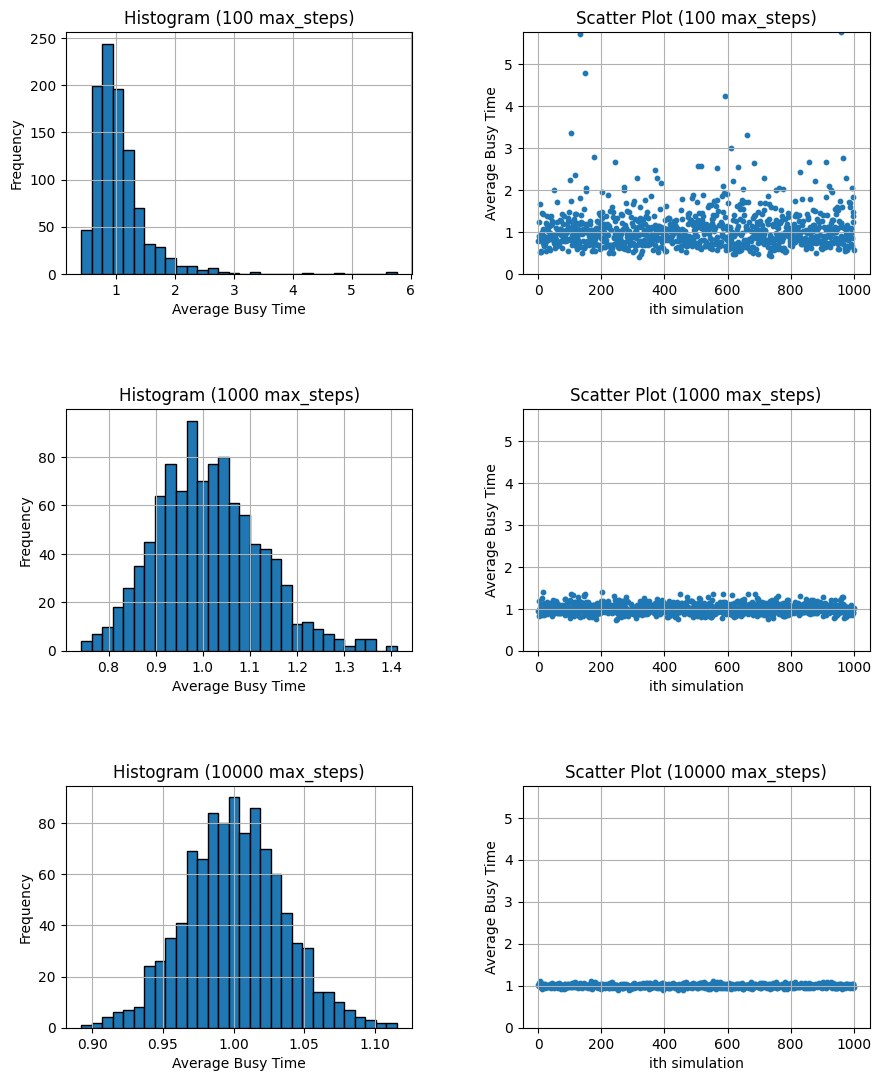

In [77]:
make_plots(1, 2, 1000, field="average_busy_time")

In [89]:
def make_simple_plots(arrival_rate, service_rate, n_simulations, is_deterministic=False, simulation_function=simulate3, field="average_busy_time"):
  fig, axes = plt.subplots(2, 2, figsize=(10, 8))

  max_steps = 100000
  
  words = field.split('_')
  capitalized_words = [word.capitalize() for word in words]
  pretty_field = ' '.join(capitalized_words)

  for i in range(1,2):
    averages = [simulation_function(arrival_rate, service_rate, max_steps, determ_service=is_deterministic, starting_clients=i)[field] for _ in range(n_simulations)]
    confidence_min, confidence_max = get_confidence_interval(averages)
    print(f"Intervalo de Confiança (max_steps: {max_steps}): [{confidence_min}, {confidence_max}]")

    ylim = max(averages)
    
    # Histogram
    axes[i-1][0].hist(averages, bins=30, edgecolor='black')
    axes[i-1][0].set_xlabel(pretty_field)
    axes[i-1][0].set_ylabel('Frequency')
    axes[i-1][0].set_title(f'Histogram ({max_steps} max_steps)')

    # Scatter Plot
    axes[i-1][1].scatter(range(1, n_simulations + 1), averages, s=10)
    axes[i-1][1].set_xlabel('ith simulation')
    axes[i-1][1].set_ylabel(pretty_field)
    axes[i-1][1].set_ylim(0, ylim)
    axes[i-1][1].set_title(f'Scatter Plot ({max_steps} max_steps)')

    axes[i-1][0].grid(True)
    axes[i-1][1].grid(True)


  fig.tight_layout(pad=5.0)
  plt.show()

Intervalo de Confiança (max_steps: 100000): [0.0, 0.0]


C:\Users\eduar\AppData\Local\Temp\ipykernel_3280\1440906007.py:27: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i-1][1].set_ylim(0, ylim)


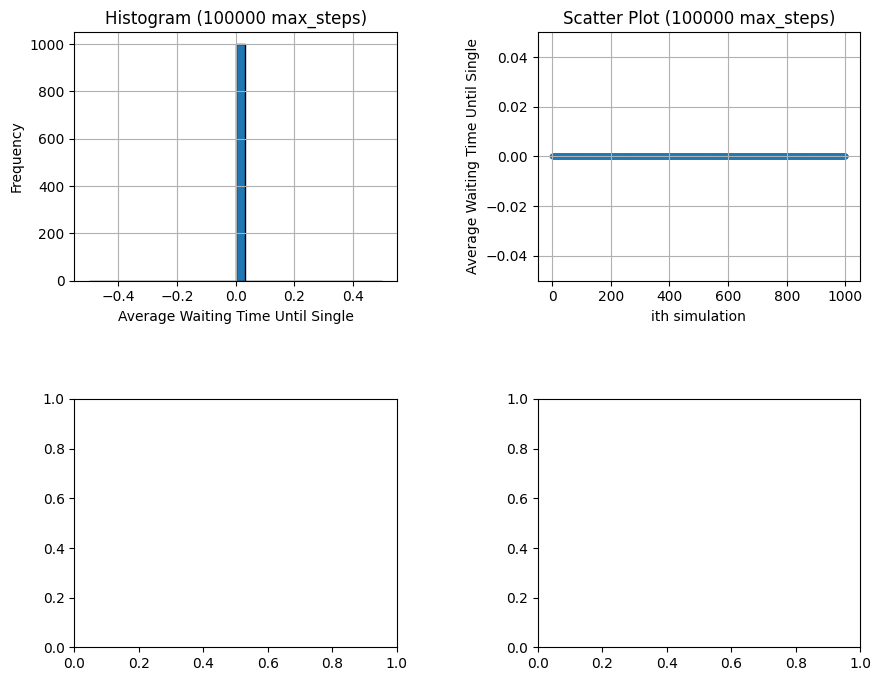

In [90]:
make_simple_plots(1, 2, 1000, is_deterministic=False, simulation_function=simulate3, field="average_waiting_time_until_single")

Intervalo de Confiança (max_steps: 100): [0.23965391691691354, 0.2507180888207244]
Intervalo de Confiança (max_steps: 1000): [0.24691491275521651, 0.250513375668108]
Intervalo de Confiança (max_steps: 10000): [0.24944213566191553, 0.25054736943740596]


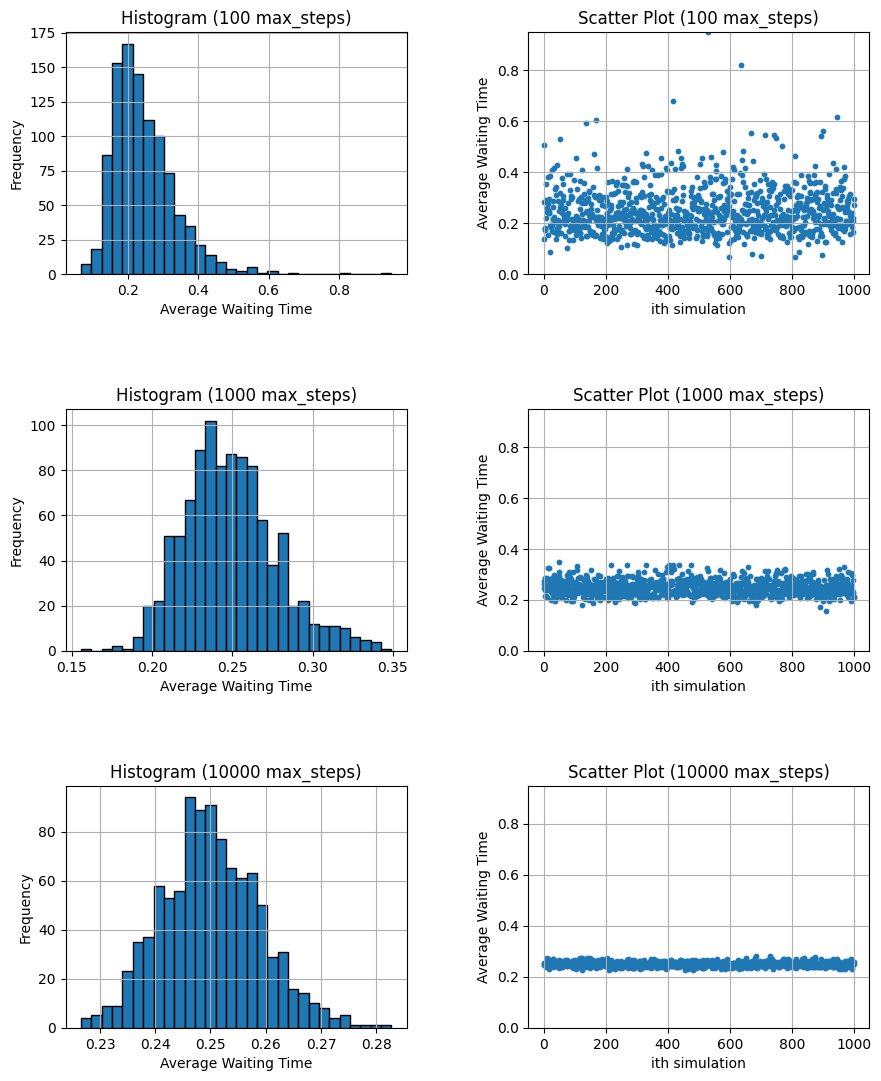

In [18]:
make_plots(1, 2, 1000, is_deterministic=True, simulation_function=simulate2)